**Avant de débuter ce TP** :

1. **Changez le type d'exécution sur Google Colab** : `Exécution > Modifiez le type d'exécution > T4 GPU`
2. **Installez les paquets ci-dessous** :

In [ ]:
! pip install lightning torchmetrics torchinfo pyconll

3. Exécutez ce code pour supprimer quelques messages et avertissements éventuellement affichés.

In [1]:
import logging
logging.getLogger("lightning").setLevel(logging.ERROR)
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)
logger = logging.getLogger("lightning")
logger.propagate = False

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*Missing logger folder.*")

# Exercice de grammaire par transformeur

Dans ce notebook, nous allons à nouveau travailler sur le jeu de données [noun verb](https://github.com/google-research-datasets/noun-verb).
Ce jeu de données contient des phrases en anglais naturelles où il peut y avoir une certaine ambiguïté sur le rôle d'un mot, c'est-à-dire de savoir s'il s'agit d'un nom ou d'un verbe.

Vous trouverez ci-dessous quelques observations de ce jeu de données illustrant la tâche. Le mot en gras est le mot à classer et le mot en italique après la phrase indique la bonne réponse :

> Certain insects can damage plumerias, such as mites, **flies**, or aphids. *NOUN*

> **Mark** which area you want to distress. *VERB*

Par exemple, le mot **flies** peut correspondre à la troisième personne au singulier du verbe *fly* (par exemple *time flies by so fast*), mais également au pluriel du nom *fly* (mouche).
De même, le mot **mark** peut correspondre au verbe *mark* (marquer) ou au nom *mark* (marque).

Le tâche est donc une classification binaire car il n'y a que deux classes possibles : *nom* ou *verbe*.

## Chargement et prétraitement des données

Nous allons appliquer les mêmes étapes de prétraitement des données que dans l'autre notebook, c'est-à-dire transformer chaque token en un vecteur numérique à $50$ dimensions en utilisant les *embeddings* GloVe.

In [ ]:
! mkdir data && cd data && wget https://nlp.stanford.edu/data/glove.6B.zip && unzip glove.6B.zip

In [2]:
import numpy as np
import torch


def load_dataset(path='data'):
    """Load the noun verb dataset.

    Parameters
    ----------
    path : str
        Chemin du répertoire.

    Returns
    -------
    train : Conll
        Jeu d'entraînement.

    validation : Conll
        Jeu de validation.

    test : Conll
        Jeu d'évaluation.

    """
    import os
    import pyconll
    from urllib.request import urlretrieve

    if not os.path.exists(path):
        os.makedirs(path)
    
    files = ('train.conll', 'dev.conll', 'test.conll')

    # Downloads the files if necessary
    for file in files:
        if not os.path.isfile(os.path.join(path, file)):
            url = f'https://raw.githubusercontent.com/google-research-datasets/noun-verb/master/{file}'
            urlretrieve(url, os.path.join(path, file))

    return (pyconll.load_from_file(os.path.join(path, file)) for file in files)


def load_embeddings(path='data'):
    """Charge les représentations vectorielles GloVe 50d.
    
    Parameters
    ----------
    path : str
        Chemin du le répertoire.
    
    Returns
    -------
    embeddings : dict
        Représentations vectorielles GloVe 50d.

    """
    import os

    # Save the results in a dictionary
    embeddings = {}

    # Get the embedding for each token in the file
    mean = torch.zeros(50, dtype=torch.float32)
    with open(os.path.join(path, 'glove.6B.50d.txt'), 'r') as file:
        for line in file.readlines():
            split = line.strip().split(' ')
            token = split[0]
            value = torch.from_numpy(np.array(split[1:], dtype=np.float32))
            embeddings[token] = value
            mean += value

    # Define the mean embedding for out-of-vocabulary token
    embeddings['out_of_vocabulary'] = mean / len(embeddings)

    return embeddings


def preprocess_dataset(dataset):
    """Prétraite un jeu de données.

    Parameters
    ----------
    dataset : Conll
        Jeu de données.

    Returns
    -------
    X : list[Tensors]
        Phrases prétraitées.

    y : Tensor
        Labels rétraités.
    
    index : Tensor
        Indices des tokens à prédire.
    """
    
    X = []
    y = []
    index = []
    mapping = []

    label_mapping = {'NON-VERB': 0, 'VERB': 1}

    for count, sentence in enumerate(dataset):

        embedded_sentence = []
        label = None
        idx = None

        for i, token in enumerate(sentence):

            # Get the token in lower cases
            token_lower = token.form.lower()

            # Get the embedding of the token
            if token_lower in embeddings.keys():
                embedded_sentence.append(embeddings[token_lower].reshape(1, -1))
            else:
                embedded_sentence.append(embeddings['out_of_vocabulary'].reshape(1, -1))

            # Get the label (if any)
            if len(token.feats):
                if label is not None:
                    raise ValueError("Two annotated tokens in a single sentence.")
                label = label_mapping[next(iter(token.feats['POS']))]
                idx = i

        # Add the preprocessed sample to the dataset only if there is a label available
        if label is not None:
            X.append(torch.concat(embedded_sentence))
            y.append(label)
            index.append(idx)
            mapping.append(count)

    y = torch.tensor(y).to(dtype=torch.float32)
    index = torch.tensor(index).to(dtype=torch.int64)

    return X, y, index, mapping

In [3]:
# Load the dataset
training, validation, test = load_dataset()

# Load the embeddings
embeddings = load_embeddings()

# Preprocess the dataset
X_train, y_train, index_train, mapping_train = preprocess_dataset(training)
X_val, y_val, index_val, mapping_val = preprocess_dataset(validation)
X_test, y_test, index_test, mapping_test = preprocess_dataset(test)

## Rappel

Dans un TP précédent, nous avons utilisé un réseau de neurones récurrent bidirectionnel.
L'image ci-dessous résume l'architecture que nous avons implémentée :

[<img src="../figures/brnn_specific_token.png" width="450"/>](../figures/brnn_specific_token.png)

Cette approche a plusieurs limites :

* Dans la direction avant, seuls les tokens situés avant le token d'intérêt sont prise en compte. De même, dans la direction arrière, seuls les tokens situés après le token d'intérêt sont pris en compte. En concaténant les deux états cachés, tous les tokens sont pris en compte, mais cela n'intervient que plus tard dans l'architecture.

* L'état caché du token d'intérêt doit contenir toute l'information pertinente contenu dans tous les tokens précédents, ce qui peut être difficile pour de longues phrases.


## Mécanisme d'attention

L'idée principale du mécanisme d'attention est la suivante : au lieu de prendre en compte un seul état caché obtenu par un réseau de neurones récurrent, on peut prendre en compte toutes les entrées en utilisant une **combinaison convexe** des entrées.
Ainsi, un vecteur caché n'a plus à contenir toute l'inforformation pertinente car on aura une couche dédiée pour aller chercher les informations pertinentes dans les entrées correspondantes à travers des *poids d'attention*.

Une fonction d'attention peut être décrite comme une correspondance entre une *requête* et un ensemble de paires de (*clés*, *valeurs*) pour renvoyer une sortie.
La requête, chaque clé, chaque valeur et la sortie sont des vecteurs numériques.
Cette sortie est calculée comme une somme pondérée des valeurs, où les poids sont calculés en fonction de la similarité entre la requête et les clés.

Il existe plusieurs fonctions mathématiques pour calculer .
Ici, la fonction considérée est l'attention basée sur le produit scalaire échelonné (*scaled dot-product attention*) :
$$
    \text{Attention}(Q, K, V) = \text{softmax}\left( \frac{Q K^\top}{\sqrt{d_k}} \right) V
$$
où $Q$, $K$ et $V$ sont les matrices correspondant aux requêtes, aux clés et aux valeurs respectivement, et où $d_k$ est la dimension des vecteurs des requêtes et des clés.
L'échelonnage est fait pour empêcher l'échelle des produits scalaires de dépendre trop de la dimension $d_k$.


### Attention multi-tête

L'idée principale de l'attention multi-tête est de simplement effectuer plusieurs fonctions d'attention au lieu d'une seule, mais sans changer la dimension totale.
Pour ce faire, chaque fonction d'attention se fait en plus petites dimensions en projetant linéairement les requêtes, les clés et les valeurs dans différents espaces de plus faible dimension :
$$
    \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h) W^O \\
    \text{où } \text{head}_i = \text{Attention}(Q W_i^Q, K W_i^K, V W_i^V) 
$$

The main idea of multi-head attention is simply to perform several attention functions instead of a single one, but without increasing the dimension. It is done by linearly projecting the queries, keys and values $h$ times with different, learned linear projections:
$$
    \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h) W^O \\
    \text{where } \text{head}_i = \text{Attention}(Q W_i^Q, K W_i^K, V W_i^V) 
$$

L'image ci-dessous illustre l'attention basée sur le produit scalaire échelonné (à gauche) et l'attention multi-tête (à droite) :

[<img src="../figures/attention.png" width="650"/>](../figures/attention.png)

## Implémentation dans `PyTorch`

L'attention multi-tête est implémentée dans la classe [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
Les arguments obligatoires de cette classe sont :
* `embed_dim` : dimension des vecteurs (les requêtes, les clés et les valeurs),
* `num_heads` : nombre de têtes d'attention.
Veuillez noter que la dimension totale `embed_dim` est répartie entre les têtes, c'est-à-dire que chaque tête est de dimension `embed_dim / num_heads`.

Pour appliquer la passe avant de cette couche, il est nécessaire de fournir en entrée au minimum trois arguments obligatoires : `query` (les requêtes), `key` (les clés) and `value` (les valeurs).
Un argument optionnel, `key_padding_mask`, permet d'indiquer quels éléments parmi les clés ignorer dans le calcul de l'attention.
Plus d'informations à ce sujet dans la section suivante.


### Rembourrage (*padding*)

Avec des données séquentielles, on se retrouve souvent à travailler avec des tenseurs de longueur variable.
Comme avec les réseaux de neurones récurrents, on utilise le rembourrage (*padding*), c'est-à-dire ajouter éventuellement des zéros à la fin des tenseurs, pour que toutes les observations potentiellement rembourrées du lot aient la même longueur.
Cependant, il est nécessaire d'indiquer quells valeurs ont été rembourrées afin que la fonction d'attention ne les utilise pas.
C'est exactement ce que l'argument `key_padding_mask` permet de faire.
Une représentation possible est un masque binaire où les valeurs `True` indiquent les éléments à ignorer.
Le code ci-dessous illustre comment rembourrer une liste de séquences et comment calculer le masque de rembourrage.

```python
import torch

sequence1 = torch.rand(6, 50)  # une séquence de longueur 6
sequence2 = torch.rand(10, 50)  # une séquence de longueur 10
sequence3 = torch.rand(9, 50)  # une séquence de longueur 9

sequences = [sequence1, sequence2, sequence3]

# On calcule la longueur de chacune des séquences
lens = [sequence.size()[0] for sequence in sequences]
max_len = max(lens)

# On génère le masque de rembourrage pour la couche d'attention.
key_padding_mask = torch.vstack([
    torch.cat((torch.full((length,), False), torch.full((max_len - length,), True)))
    for length in lens
])

# On rembourre la liste de séquences
sequences_padded = pad_sequence(sequences)
```

### Question 1

On va construire un réseau de neurones récurrent avec l'architecture suivante :

* Première couche : attention multi-tête avec une seule tête.
* Deuxième couche : couche linéaire avec 50 variables en entrée et 32 variables en sortie + fonction d'action ReLU.
* Troisième couche : couche linéaire avec 1 variable en sortie.

Pour la couche d'attention, vous utiliserez [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
Prenez le temps de lire la documentation de cette classe.

Quelques remarques importantes :

* La méthode `forward()` de [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) a un argument appelé `need_weights` dont la valeur par défaut est `True`. La documentation propose de remplacer cette valeur par `False` pour utiliser une version plus optimisée et obtenir la meilleure performance. Bien que notre modèle n'utilise pas les poids d'attention, on va laisser la valeur de cet argument à `True` afin de visualiser les poids obtenus. **En particulier, la méthode `forward()` de la classe `AttentionNetwork()` doit renvoyer les poids d'attention**. 
* La couche d'attention va renvoyer renvoyer les sorties d'attention et les poids d'attention pour tous les tokens. On ne s'intéresse qu'à la sortie et aux poids pour le token d'intérêt (correspondant au mot à labéliser).

Complétez le code manquant dans les méthodes `__init__()` et `forward()` de la classe `AttentionNetwork()`.

In [4]:
import lightning as L
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy


class AttentionNetwork(L.LightningModule):
    def __init__(self, num_heads=1):
        super().__init__()

        ### BEGIN TODO ###
        self.attention = torch.nn.MultiheadAttention(embed_dim=50, num_heads=num_heads)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(50, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1)
        )
        #### END TODO ####

        self.loss = torch.nn.BCEWithLogitsLoss()

        self.accuracy_train = Accuracy(task="binary")
        self.accuracy_val = Accuracy(task="binary")
        self.accuracy_test = Accuracy(task="binary")

    def forward(self, X, index):
        """Passe avant.
        
        Parameters
        ----------
        X : list[Tensor], len = batch_size
            Lot de séquences de vecteurs.
        
        index : tensor, shape = (batch_size,)
            Indice du token d'intérêt dans chacune des séquences.

        Returns
        -------
        logits : Tensor, shape = (batch_size,)
            Logits.
        
        attn_weights : list[Tensor], len = batch_size
            Liste des poids d'attention pour chaque token d'intérêt.
        """
        ### BEGIN TODO ###
        # Calcule la longueur de chacune des séquences
        lens = [sequence.size()[0] for sequence in X]
        max_len = max(lens)

        # Génère le masque de rembourrage
        key_padding_mask = torch.vstack([
            torch.concat((torch.full((length,), False), torch.full((max_len - length,), True)))
            for length in lens
        ]).to(self.device)

        # Rembourre la liste des tenseurs
        X_padded = pad_sequence(X)
        
        # Récupère uniquement les requêtes pour les tokens d'intérêt
        X_query = torch.unsqueeze(
            torch.stack([X_padded[idx, i] for i, idx in enumerate(index)]), dim=0
        )

        # Calcule les sorties et les poids d'attention
        h, attn_output_weights = self.attention(
            X_query, X_padded, X_padded, key_padding_mask=key_padding_mask
        )
        h = torch.squeeze(h, dim=0)
        
        # Enlève le padding dans les poids d'attention
        attn_weights = [
            attn_output_weights[i, 0, :length] for i, length in enumerate(lens)
        ]
        
        # Applique le perceptron multicouche
        logits = torch.squeeze(self.mlp(h), dim=1)
        #### END TODO ####

        return logits, attn_weights
    
    def step(self, batch, dataset):
        """Effectue une étape.

        Une étape consiste à passer d'un lot d'observations (l'argument batch)
        à l'évaluation de la fonction de coût pour ce lot d'observations.

        Parameters
        ----------
        batch : tuple
            Un lot d'observations. Le premier élément du tuple est le lot
            des entrées, le second est le lot des labels.

        dataset : {"training", "validation", "test"}
            Jeu de données utilisé.

        Returns
        -------
        loss : Tensor, shape = (1,)
            La fonction de coût pour ce lot d'observations.
        """
        # Récupère les données du lot d'observations
        X = [item[0].to(self.device) for item in batch]
        y = torch.tensor([item[1] for item in batch], device=self.device)
        index = torch.tensor([item[2] for item in batch], device=self.device)
        
        logits, _ = self(X, index)  # Passe avant, qui renvoie les logits
        loss = self.loss(logits, y)  # Évaluation de la fonction de coût
        y_pred = (logits > 0).to(torch.float32)  # Prédictions du modèle
 
        if dataset == "training":
            metric = self.accuracy_train
            name = "train"
            bar_step = True
        elif dataset == "validation":
            metric = self.accuracy_val
            name = "val"
            bar_step = False
        else:
            metric = self.accuracy_test
            name = "test"
            bar_step = False
        
        acc = metric(y_pred, y)  # Évaluation de la métrique
        self.log(f"loss_{name}", loss, batch_size=len(y), prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        self.log(f"accuracy_{name}", acc, batch_size=len(y), prog_bar=bar_step, on_step=bar_step, on_epoch=True)

        return loss

    def training_step(self, batch):
        """Effectue une étape d'entraînement."""
        return self.step(batch, "training")

    def validation_step(self, batch):
        """Effectue une étape de validation."""
        return self.step(batch, "validation")

    def test_step(self, batch):
        """Effectue une étape d'évaluation."""
        return self.step(batch, "test")
    
    def on_train_start(self):
        """Code exécuté au début de l'entraînement."""
        string = f"Version {self.trainer.logger.version}"
        print(f"{string}\n{'=' * len(string)}\n")

    def on_train_epoch_end(self):
        """Code exécuté à la fin de chaque époque d'entraînement."""
        metrics = self.trainer.callback_metrics
        string = (f"""
            Époque {self.trainer.current_epoch + 1} / {self.trainer.max_epochs}
            -------------------------------------------------
            |     Jeu      | Fonction de perte | Exactitude |
            | ------------ | ----------------- | ---------- |
            | Entraînement |{metrics['loss_train'].item():^19.5f}|{metrics['accuracy_train'].item():^12.3%}|
            |  Validation  |{metrics['loss_val'].item():^19.5f}|{metrics['accuracy_val'].item():^12.3%}|
            -------------------------------------------------
        """)
        string = '\n'.join([line.strip() for line in string.strip().split('\n')])
        print(string, "\n")

    def configure_optimizers(self):
        """Configure l'algorithme d'optimisation à utiliser."""
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

### Jeux de données (*datasets*) et chargeurs de données (*dataloaders*)

Étant donné que le code relatif aux jeux et chargeurs de données reste inchangé par rapport au notebook précédent, il vous est fourni ci-dessous :

In [5]:
from torch.utils.data import DataLoader, TensorDataset


dataloader_train = DataLoader(
    TensorDataset(X_train, y_train, index_train),
    batch_size=64, shuffle=True, collate_fn=lambda x: x
)

dataloader_val = DataLoader(
    TensorDataset(X_val, y_val, index_val),
    batch_size=64, shuffle=False, collate_fn=lambda x: x
)

dataloader_test = DataLoader(
    TensorDataset(X_test, y_test, index_test),
    batch_size=64, shuffle=False, collate_fn=lambda x: x
)

### Entraînement

On va entraîner notre modèle pendant 10 époques.

In [6]:
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger


model_attention = AttentionNetwork()

trainer_attention = L.Trainer(
    max_epochs=10,
    enable_model_summary=False,
    logger=CSVLogger('.'),
    num_sanity_val_steps=0,
    callbacks=[TQDMProgressBar(refresh_rate=10)]
)

trainer_attention.fit(
    model=model_attention,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)

Training: |                                               | 0/? [00:00<?, ?it/s]

Version 0



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 1 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.61176      |  66.339%  |
|  Validation  |      0.59683      |  69.244%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 2 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.57658      |  69.556%  |
|  Validation  |      0.58976      |  69.455%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 3 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.56178      |  71.258%  |
|  Validation  |      0.60045      |  65.737%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 4 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.55256      |  71.919%  |
|  Validation  |      0.59511      |  68.314%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 5 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.54211      |  72.824%  |
|  Validation  |      0.58414      |  70.173%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 6 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.53354      |  73.626%  |
|  Validation  |      0.57896      |  70.300%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 7 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.52663      |  74.226%  |
|  Validation  |      0.57790      |  71.103%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 8 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.52177      |  74.436%  |
|  Validation  |      0.58336      |  70.849%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 9 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.51762      |  74.813%  |
|  Validation  |      0.58172      |  71.018%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 10 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.51129      |  75.538%  |
|  Validation  |      0.58582      |  71.779%  |
------------------------------------------------



## Visualisation

Maintenant que l'on a entraîné notre modèle avec une couche d'attention, on peut visualiser les poids d'attention donnés aux différents tokens d'une phrase pour voir quels mots sont considérés comme importants pour la classification.

La fonction `plot_attention_weights()` définie ci-dessous affiche les poids d'attention pour une phrase donnée.

In [7]:
import matplotlib.pyplot as plt


def plot_attention_weights(model, dataset, idx, **kwargs):
    """Plot a sample from a given dataset and a given index, as well 
    as the attention weights learned by the model.
    
    Parameters
    ----------
    model : LightingModule
        Modèle entraîné.
    
    dataset : {'train', 'validation', 'test'}
        Jeu de données.
    
    idx : int
        Indice de l'observation dans le jeu de données.
        
    kwargs : optional
        Autres arguments fournis en entrée de la méthode `forward()`
        du modèle entraîné.
    """
    
    if dataset == 'train':
        dataset = training
        X = X_train
        y = y_train
        index = index_train
        mapping = mapping_train
    elif dataset == 'validation':
        dataset = validation
        X = X_val
        y = y_val
        index = index_val
        mapping = mapping_val
    elif dataset == 'test':
        dataset = test
        X = X_test
        y = y_test
        index = index_test
        mapping = mapping_test
        
    # Check if the index is valid
    if not (0 <= idx < len(y)):
        raise ValueError(
            f"L'indice fourni n'est pas valable pour ce jeu de données. "
            f"La taille de ce jeu de données est de {len(y)}."
        )
    
    # Get original labels
    label_inverse_mapping = {False: 'NOUN', True: 'VERB'}
    
    # Compute prediction and attention weights
    pred, attn = model(X[idx:idx+1], index[idx:idx+1], **kwargs)
    y_pred = label_inverse_mapping[pred.item() > 0]

    # Plot the results
    plt.figure(figsize=(14, 2))
    plt.imshow(attn[0].detach().numpy().reshape(1, -1), cmap='seismic', vmin=0., vmax=1.)
    plt.xticks(-0.5 + np.arange(0, len(X[idx])), [])
    plt.yticks([])
    plt.tick_params(length=0)

    for i, token in enumerate(dataset[mapping[idx]]):
        if i == index[idx:idx+1]:
            color = 'C0'
            fontweight = 'bold'
        else:
            color = 'k'
            fontweight = 'normal'
        plt.text(i, -0.6, token.form, color=color, rotation=45, fontweight=fontweight, ha='left')

    plt.grid(which='major', color='C2', linestyle='--', linewidth=2)

    colorbar = plt.colorbar(orientation='horizontal')
    colorbar.set_ticks(np.linspace(0, 1, 6))
    colorbar.set_ticklabels([f'{tick: >.1f}' for tick in np.linspace(0, 1, 6)])
    
    print(f"True label: {label_inverse_mapping[y[idx].item() == 1]}")
    print(f"Predicted label: {label_inverse_mapping[pred.item() > 0]}")

### Question 2

Utilisez la fonction `plot_attention_weights()` pour afficher les poids d'attention de chaque token pour quelques phrases des jeux d'entraînement, de validation et d'évaluation.

True label: NOUN
Predicted label: VERB


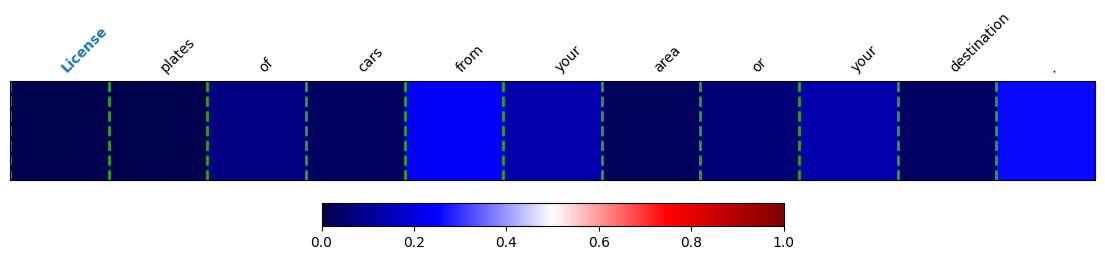

In [8]:
plot_attention_weights(model_attention, 'train', 0)

True label: VERB
Predicted label: VERB


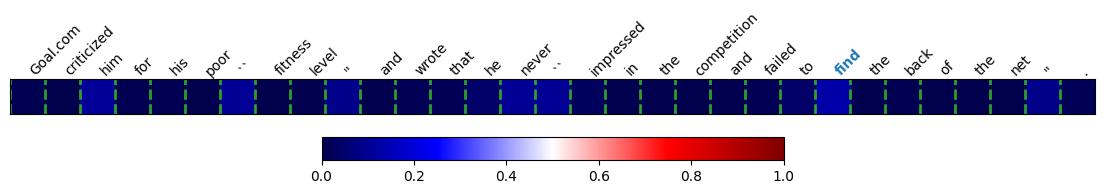

In [9]:
plot_attention_weights(model_attention, 'train', 2023)

True label: VERB
Predicted label: VERB


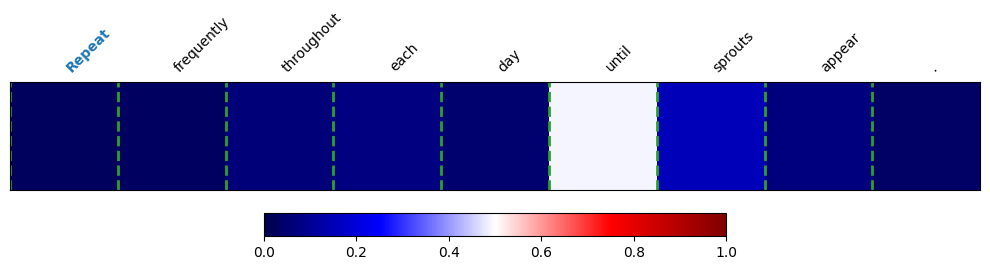

In [10]:
plot_attention_weights(model_attention, 'validation', 20)

True label: NOUN
Predicted label: NOUN


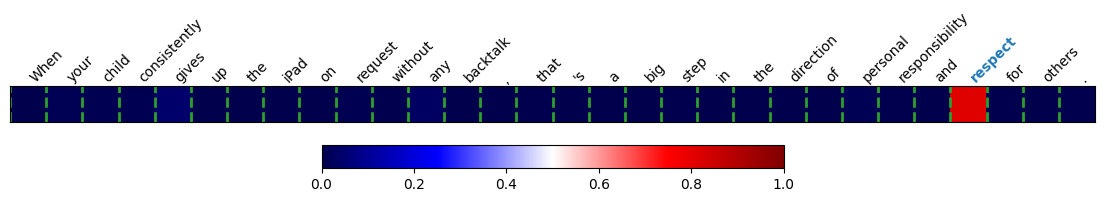

In [11]:
plot_attention_weights(model_attention, 'validation', 23)

True label: VERB
Predicted label: VERB


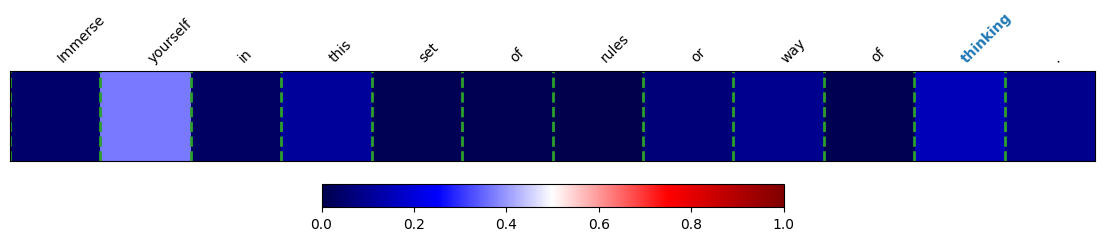

In [12]:
plot_attention_weights(model_attention, 'test', 22)

True label: VERB
Predicted label: NOUN


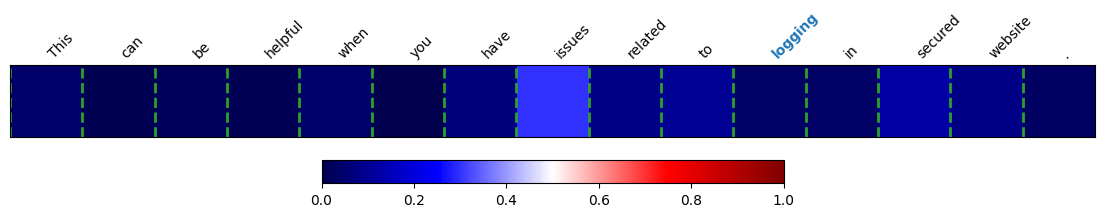

In [13]:
plot_attention_weights(model_attention, 'test', 43)

Vous avez peut-être remarqué que la performance d'une modèle n'est pas exceptionnelle, avec un score de précision (*accuracy*), c'est-à-dire la proportion de bonnes réponses, d'environ $70\%$.
Pour rappel, avec un modèle trivial en ne prédisant que des verbes, on obtiendrait les performances suivantes :

In [14]:
print(f"Propotion de verbes dans le jeu d'entraînement : {y_train.mean().item():.2%}")
print(f"Propotion de verbes dans le jeu de validation : {y_val.mean().item():.2%}")
print(f"Propotion de verbes dans le jeu d'évaluation : {y_test.mean().item():.2%}")

Propotion de verbes dans le jeu d'entraînement : 63.57%
Propotion de verbes dans le jeu de validation : 66.37%
Propotion de verbes dans le jeu d'évaluation : 65.82%


Le module d'attention est un élément essentiel de l'architecture d'un transformeur, mais cette architecture est bien plus complexe et n'utilise pas qu'un seul module d'attention.

## Transformeur

L'image ci-dessous illustre l'architecture d'un transformeur : 

[<img src="../figures/transformer.png" width="450"/>](../figures/transformer.png)

Cette architecture est composée de deux parties :

* L'encodeur (à gauche) est constitué d'une pile de $N$ ($N = 6$ dans l'architecture originale) couches d'encodage ayant toutes la même architecture. Chaque couche d'encodage est composée de deux sous-couches. La première sous-couche correspond l'attention multi-tête, tandis que la seconde sous-couche est un simple perceptron multicouche (2 couches linéaires avec la fonction d'activation ReLU entre les deux).

* Le décodeur (à droite) est constitué d'une pile de $N$ ($N = 6$ dans l'architecture originale) couches de décodage ayant toutes la même architecture. Chaque couche de décodage est composée de deux sous-couches. 


### Implémentation dans `PyTorch`

`PyTorch` met à disposition plusieurs classes pour les [différentes couches d'un transformeur](https://pytorch.org/docs/stable/nn.html#transformer-layers) :

* [`torch.nn.Transformer()`](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) : un transformeur complet.
* [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html) : un encodeur de transformeur (c'est-à-dire une pile de plusieurs couches d'encodage de transformeur).
* [`torch.nn.TransformerDecoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html) : un décodeur de transformeur (c'est-à-dire une pile de plusieurs couches de décodage de transformeur).
* [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html) : une couche d'encodage d'un transformeur.
* [`torch.nn.TransformerDecoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoderLayer.html) : une couche de décodage d'un transformeur.


### Question 3

On va construire un modèle dont l'architecture est basée sur celle du transformeur.
L'encodeur sert à apprendre un code de l'entrée.
Le décodeur d'un transformeur sert à générer la séquence en sortie à partir du code de l'entrée (par exemple la traduction d'une phrase).
Ici, nous n'avons pas besoin de générer une séquence en sortie, nous n'avons donc pas besoin du décodeur.

L'encodeur du transformeur renvoie un code de la séquence en entrée, c'est-à-dire un code pour chacun des tokens de la phrase.
Nous ne sommes intéressés que par le code du token d'intérêt (le mot à labéliser), nous ne garderons donc que ce code dans la sortie.

L'architecture de notre modèle sera la suivante :
* *Première couche* : encodeur de transformeur ;
* *Deuxième couche* : couche linéaire avec $50$ variables en entrée et $1$ variable en sortie.

Complétez le code manquant dans la méthode `__init__()` de la classe `TransformerNetwork()`.

In [15]:
class TransformerNetwork(L.LightningModule):
    """
    
    Parameters
    ----------
    num_layers : int (default = 6)
        Nombre de couches d'encodage.
        
    nhead : int (default = 5)
        Nombre de têtes dans l'attention multi-tête.
    
    dropout_encoder_layer : float (default = 0.0)
        Taux de dropout de chaque couche d'encodage.
    """
    def __init__(self, num_layers=6, nhead=5, dropout_encoder_layer=0.0):
        super().__init__()
        
        ### BEGIN TODO ###
        self.transformer_encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(
                d_model=50, nhead=nhead, dropout=dropout_encoder_layer
            ),
            num_layers=num_layers, enable_nested_tensor=False
        )
        self.linear = torch.nn.Linear(50, 1)
        #### END TODO ####

        self.loss = torch.nn.BCEWithLogitsLoss()
        self.accuracy_train = Accuracy(task="binary")
        self.accuracy_val = Accuracy(task="binary")
        self.accuracy_test = Accuracy(task="binary")

    def forward(self, X, index, compute_attn_weights=False):
        """Forward method.

        Parameters
        ----------
        X : list[Tensor], len = batch_size
            Sequence of embeddings.

        index : tensor, shape = (batch_size,)
            Index of the token of interest in each sequence.
        
        compute_attn_weights : False
            Si True, les poids d'attention de la première couche
            de l'encodeur sont calculés et renvoyés.

        Returns
        -------
        logits : Tensor, shape = (batch_size,)
            Logits.
        
        attn_weights : Tensor

        """
        # Calcule la longueur de chacune des séquences
        lens = [sequence.size()[0] for sequence in X]
        max_len = max(lens)
        
        # Génère le masque de rembourrage
        key_padding_mask = torch.vstack([
            torch.concat((torch.full((length,), False), torch.full((max_len - length,), True)))
            for length in lens
        ]).to(self.device)

        # Rembourre les séquences les plus petites
        X_padded = pad_sequence(X)

        # Encodeur du transformeur
        transformer_encoder_output = self.transformer_encoder(
            X_padded, src_key_padding_mask=key_padding_mask
        )

        # Récupère la sortie de l'attention pour les tokens d'intérêt seulement
        h = torch.vstack([transformer_encoder_output[idx, i] for i, idx in enumerate(index)])
        
        # Applique la couche linéaire
        logits = torch.squeeze(self.linear(h))
        
        if not compute_attn_weights:
            return logits
        
        else:
            # Calcule les poids d'attention de la première couche
            _, attn_output_weights = self.transformer_encoder.layers[0].self_attn(
                X_padded, X_padded, X_padded
            )

            # Récupère les poids de l'attention pour les tokens d'intérêt seulement
            attn_weights = [
                attn_output_weights[i, idx, :length] for i, (idx, length) in enumerate(zip(index, lens))
            ]

            return logits, attn_weights
    
    def step(self, batch, dataset):
        """Effectue une étape.

        Une étape consiste à passer d'un lot d'observations (l'argument batch)
        à l'évaluation de la fonction de coût pour ce lot d'observations.

        Parameters
        ----------
        batch : tuple
            Un lot d'observations. Le premier élément du tuple est le lot
            des entrées, le second est le lot des labels.

        dataset : {"training", "validation", "test"}
            Jeu de données utilisé.

        Returns
        -------
        loss : Tensor, shape = (1,)
            La fonction de coût pour ce lot d'observations.
        """
        # Récupère les données du lot d'observations
        X = [item[0].to(self.device) for item in batch]
        y = torch.tensor([item[1] for item in batch], device=self.device)
        index = torch.tensor([item[2] for item in batch], device=self.device)
        
        logits = self(X, index, compute_attn_weights=False)  # Passe avant, qui renvoie les logits
        loss = self.loss(logits, y)  # Évaluation de la fonction de coût
        y_pred = (logits > 0).to(torch.float32)  # Prédictions du modèle
 
        if dataset == "training":
            metric = self.accuracy_train
            name = "train"
            bar_step = True
        elif dataset == "validation":
            metric = self.accuracy_val
            name = "val"
            bar_step = False
        else:
            metric = self.accuracy_test
            name = "test"
            bar_step = False
        
        acc = metric(y_pred, y)  # Évaluation de la métrique
        self.log(f"loss_{name}", loss, batch_size=len(y), prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        self.log(f"accuracy_{name}", acc, batch_size=len(y), prog_bar=bar_step, on_step=bar_step, on_epoch=True)

        return loss

    def training_step(self, batch):
        """Effectue une étape d'entraînement."""
        return self.step(batch, "training")

    def validation_step(self, batch):
        """Effectue une étape de validation."""
        return self.step(batch, "validation")

    def test_step(self, batch):
        """Effectue une étape d'évaluation."""
        return self.step(batch, "test")
    
    def on_train_start(self):
        """Code exécuté au début de l'entraînement."""
        string = f"Version {self.trainer.logger.version}"
        print(f"{string}\n{'=' * len(string)}\n")

    def on_train_epoch_end(self):
        """Code exécuté à la fin de chaque époque d'entraînement."""
        metrics = self.trainer.callback_metrics
        string = (f"""
            Époque {self.trainer.current_epoch + 1} / {self.trainer.max_epochs}
            -------------------------------------------------
            |     Jeu      | Fonction de perte | Exactitude |
            | ------------ | ----------------- | ---------- |
            | Entraînement |{metrics['loss_train'].item():^19.5f}|{metrics['accuracy_train'].item():^12.3%}|
            |  Validation  |{metrics['loss_val'].item():^19.5f}|{metrics['accuracy_val'].item():^12.3%}|
            -------------------------------------------------
        """)
        string = '\n'.join([line.strip() for line in string.split('\n')])
        print(string)

    def configure_optimizers(self):
        """Configure l'algorithme d'optimisation à utiliser."""
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

### Question 4

Entraîner un nouveau modèle avec l'architecture définie ci-dessus, avec de $2$ couches d'encodage et $1$ tête, pendant $10$ époques.

In [16]:
### BEGIN TODO ###
model_transformer = TransformerNetwork(num_layers=2, nhead=1)
#### END TODO ####

trainer_transformer = L.Trainer(
    max_epochs=10,
    enable_model_summary=False,
    logger=CSVLogger('.'),
    num_sanity_val_steps=0,
    callbacks=[TQDMProgressBar(refresh_rate=10)]
)

trainer_transformer.fit(
    model=model_transformer,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)

Training: |                                               | 0/? [00:00<?, ?it/s]

Version 1



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 1 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.56927      |  70.688%  |
|  Validation  |      0.55097      |  73.384%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 2 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.48806      |  76.482%  |
|  Validation  |      0.53437      |  73.849%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 3 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.45296      |  78.840%  |
|  Validation  |      0.50991      |  74.694%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 4 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.42337      |  80.196%  |
|  Validation  |      0.51081      |  75.919%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 5 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.39659      |  81.812%  |
|  Validation  |      0.50617      |  75.581%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 6 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.37348      |  83.275%  |
|  Validation  |      0.52921      |  75.539%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 7 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.35038      |  84.707%  |
|  Validation  |      0.51571      |  76.637%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 8 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.32858      |  85.749%  |
|  Validation  |      0.52736      |  77.229%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 9 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.30608      |  87.023%  |
|  Validation  |      0.52776      |  76.172%  |
------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 10 / 10
------------------------------------------------
|     Jeu      | Fonction de perte | Précision |
| ------------ | ----------------- | --------- |
| Entraînement |      0.28503      |  87.945%  |
|  Validation  |      0.55193      |  76.341%  |
------------------------------------------------



### Question 5

Visualisez les poids de la première couche d'attention générés par ce nouveau modèle grâce à la fonction `plot_attention_weights()` pour quelques phrases des jeux d'entraînement, de validation et d'évaluation.

True label: NOUN
Predicted label: VERB


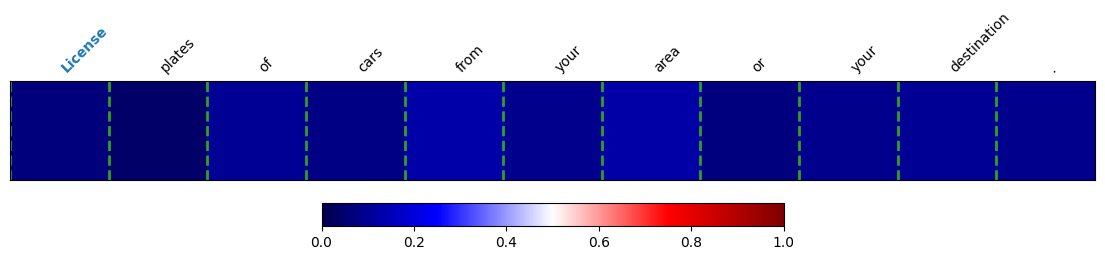

In [17]:
plot_attention_weights(model_transformer, 'train', 0, compute_attn_weights=True)

True label: NOUN
Predicted label: NOUN


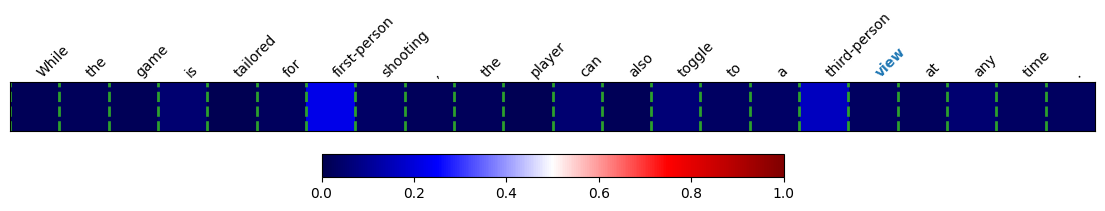

In [18]:
plot_attention_weights(model_transformer, 'train', 2024, compute_attn_weights=True)

True label: VERB
Predicted label: VERB


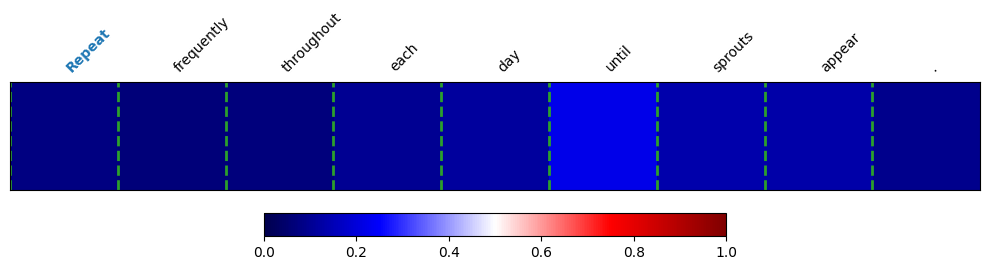

In [19]:
plot_attention_weights(model_transformer, 'validation', 20, compute_attn_weights=True)

True label: VERB
Predicted label: NOUN


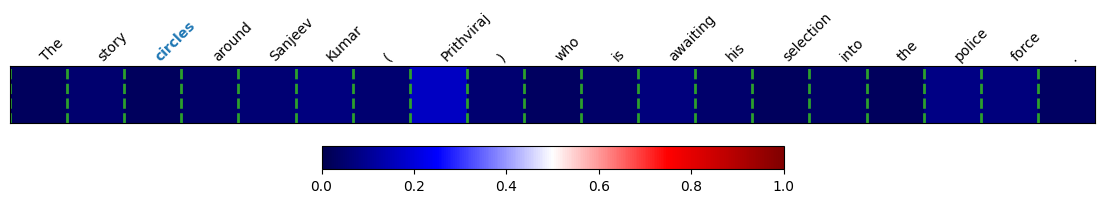

In [20]:
plot_attention_weights(model_transformer, 'validation', 24, compute_attn_weights=True)

True label: VERB
Predicted label: VERB


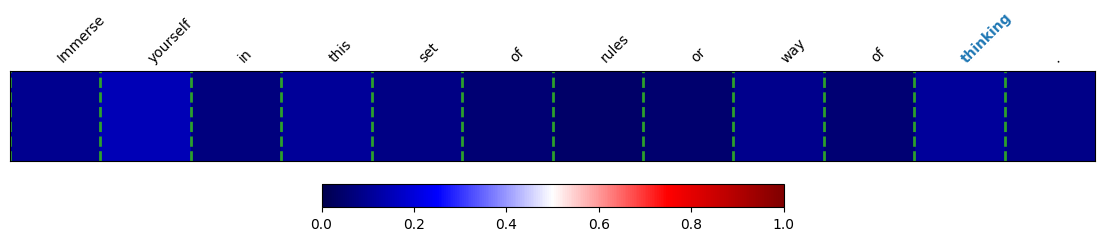

In [21]:
plot_attention_weights(model_transformer, 'test', 22, compute_attn_weights=True)

True label: NOUN
Predicted label: NOUN


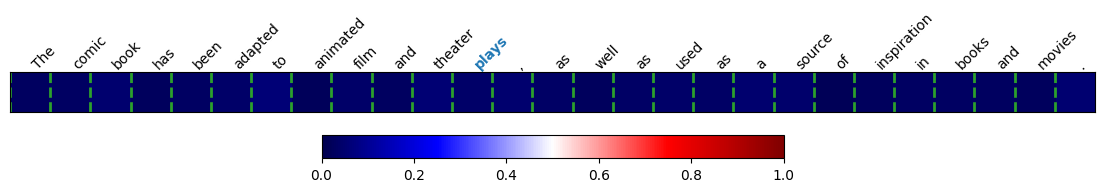

In [22]:
plot_attention_weights(model_transformer, 'test', 42, compute_attn_weights=True)